<a href="https://www.kaggle.com/code/utkarshpandey1112/vehicle-classification-preprocessing?scriptVersionId=296388274" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Import Libraries & Configuration

In [2]:
import os
import collections
import numpy as np
import tensorflow as tf
from glob import glob
import matplotlib.pyplot as plt

AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42


2026-02-07 13:32:09.173110: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770471129.363985      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770471129.412435      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770471129.827903      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770471129.827960      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770471129.827963      24 computation_placer.cc:177] computation placer alr

Dataset Link

In [3]:
DATASET_DIR = "/kaggle/input/vehicles-image-dataset/vehicle_data"


Collecting Image Paths & Labels

In [4]:
image_paths = []
labels = []

class_names = sorted(os.listdir(DATASET_DIR))
class_to_index = {name: idx for idx, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = os.path.join(DATASET_DIR, class_name)
    for img_path in glob(class_dir + "/*"):
        image_paths.append(img_path)
        labels.append(class_to_index[class_name])

print("Total images:", len(image_paths))
print("Total labels:", len(labels))
print("Total classes:", len(class_names))


Total images: 3698
Total labels: 3698
Total classes: 20


Preprocessing Step 1: Samples per Class

In [5]:
class_counts = collections.Counter(labels)

for label, count in class_counts.items():
    print(f"{class_names[label]} : {count}")


airplane : 173
ambulance : 181
bicycle : 180
boat : 191
bus : 184
car : 186
fire_truck : 184
helicopter : 184
hovercraft : 184
jet_ski : 187
kayak : 190
motorcycle : 192
rickshaw : 183
scooter : 194
segway : 187
skateboard : 188
tractor : 194
truck : 170
unicycle : 177
van : 189


Plotting Class Distribution

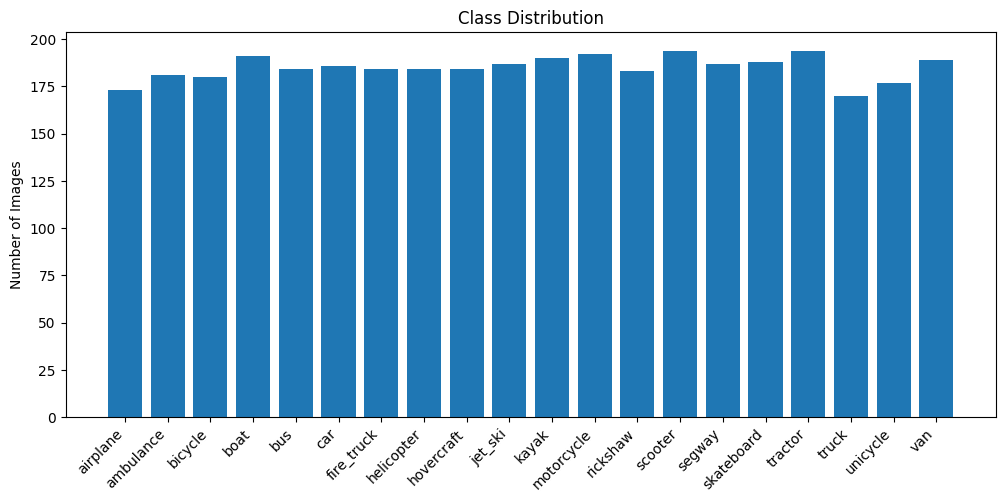

In [6]:
plt.figure(figsize=(12, 5))
plt.bar(
    [class_names[i] for i in class_counts.keys()],
    class_counts.values()
)
plt.xticks(rotation=45, ha="right")
plt.title("Class Distribution")
plt.ylabel("Number of Images")
plt.show()


Preprocessing Step 2: Class Weights

In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)

class_weight_dict = {
    i: class_weights[i] for i in range(len(class_weights))
}

print(class_weight_dict)


{0: np.float64(1.06878612716763), 1: np.float64(1.021546961325967), 2: np.float64(1.0272222222222223), 3: np.float64(0.9680628272251309), 4: np.float64(1.004891304347826), 5: np.float64(0.9940860215053764), 6: np.float64(1.004891304347826), 7: np.float64(1.004891304347826), 8: np.float64(1.004891304347826), 9: np.float64(0.9887700534759358), 10: np.float64(0.9731578947368421), 11: np.float64(0.9630208333333333), 12: np.float64(1.0103825136612021), 13: np.float64(0.9530927835051546), 14: np.float64(0.9887700534759358), 15: np.float64(0.9835106382978723), 16: np.float64(0.9530927835051546), 17: np.float64(1.0876470588235294), 18: np.float64(1.044632768361582), 19: np.float64(0.9783068783068783)}


Safe Image Loading & Decoding

In [8]:
def safe_load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0

    img.set_shape((224, 224, 3))
    label.set_shape(())

    return img, label


TensorFlow Dataset Construction

In [9]:
path_ds = tf.data.Dataset.from_tensor_slices((image_paths, labels))

image_ds = path_ds.map(
    lambda x, y: tf.py_function(
        safe_load_image, [x, y], (tf.float32, tf.int32)
    ),
    num_parallel_calls=AUTOTUNE
)


I0000 00:00:1770471143.834531      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15511 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Preprocessing Step 3: Error Handling

In [10]:
image_ds = image_ds.ignore_errors()


Train / Validation Split

In [11]:
TOTAL = len(image_paths)
train_size = int(0.8 * TOTAL)

train_ds = image_ds.take(train_size)
val_ds   = image_ds.skip(train_size)


Shape Re-Assertion

In [12]:
def fix_shape(x, y):
    x.set_shape((224, 224, 3))
    y.set_shape(())
    return x, y

train_ds = train_ds.map(fix_shape)
val_ds   = val_ds.map(fix_shape)


Preprocessing Step 4: Data Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE
)


Batching & Prefetching

In [14]:
train_ds = train_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = val_ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


Final Validation

In [15]:
for images, batch_labels in train_ds.take(1):
    print("Images shape:", images.shape)
    print("Labels shape:", batch_labels.shape)


Images shape: (32, 224, 224, 3)
Labels shape: (32,)
